# Outlier, adversarial and drift detection on CIFAR10

* [1. Dataset](#1.-Dataset)

* [2. Outlier detection with a variational autoencoder (VAE)](#2.-Outlier-detection-with-a-variational-autoencoder-(VAE))

* [3. Adversarial detection by matching prediction probabilities](#3.-Adversarial-detection-by-matching-prediction-probabilities)

* [4. Drift detection with Kolmogorov-Smirnov](#4.-Drift-detection-with-Kolmogorov-Smirnov)

## 1. Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.

Train:  (50000, 32, 32, 3) (50000,)
Test:  (10000, 32, 32, 3) (10000,)


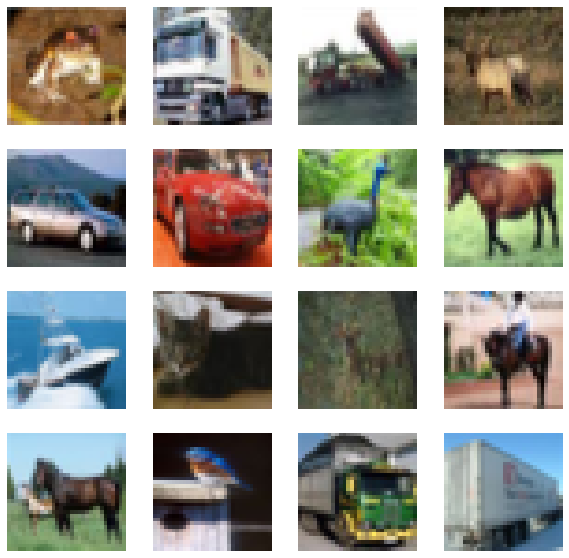

In [1]:
# imports and plot examples
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

plt.figure(figsize=(10, 10))
n = 4
for i in range(n ** 2):
    plt.subplot(n, n, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show();

## 2. Outlier detection with a variational autoencoder (VAE)

### Method

In a nutshell:

- Train a VAE on *normal* data so it can reconstruct *inliers* well
- If the VAE cannot reconstruct the incoming requests well? Outlier!

More resources on VAE: [paper](https://arxiv.org/abs/1312.6114), [excellent blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vae-variational-autoencoder)

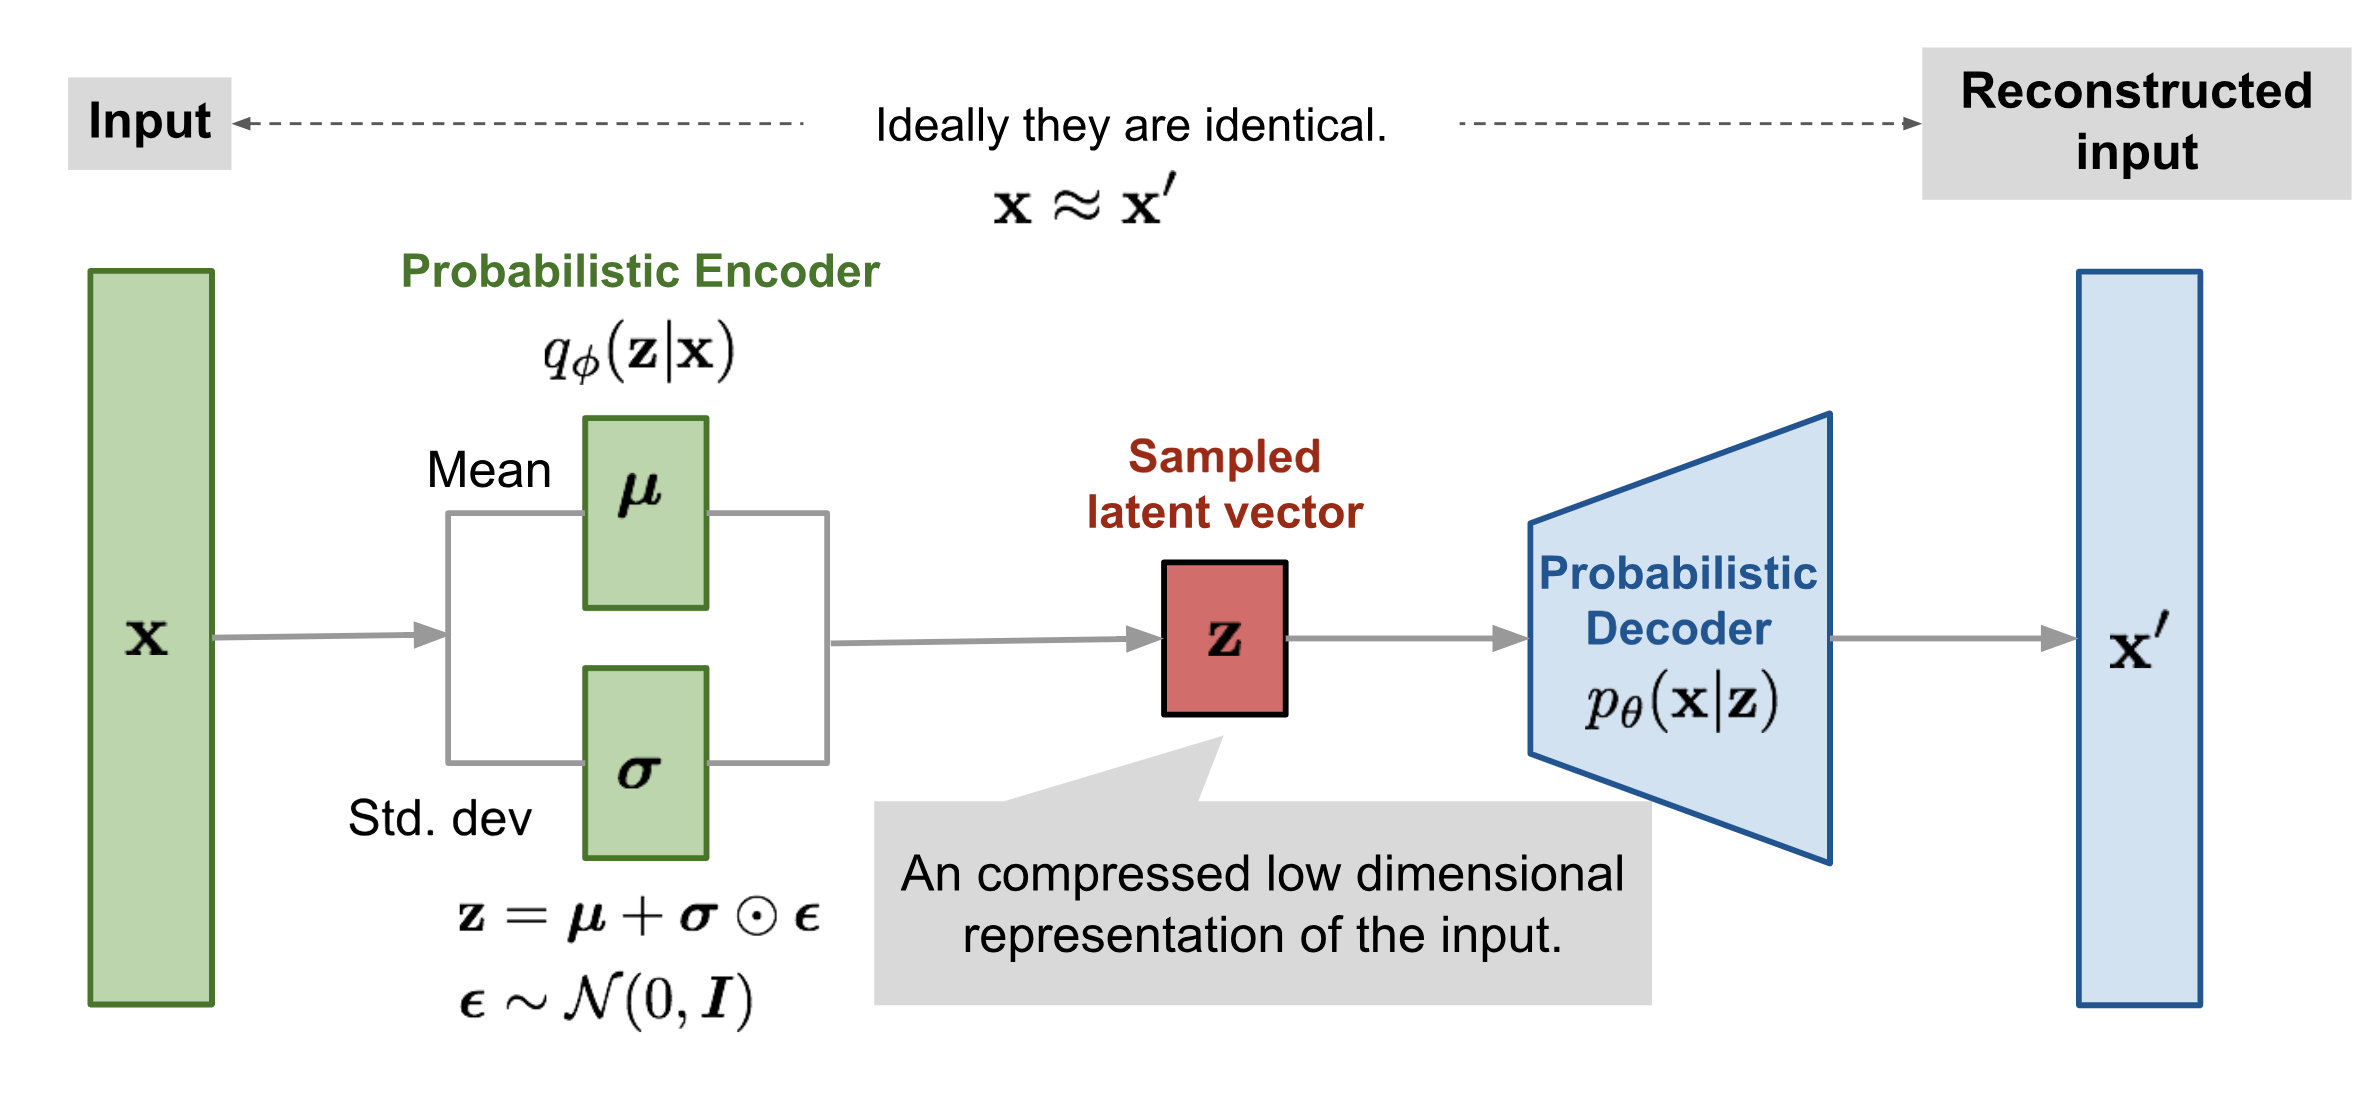

*Image source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html*

In [2]:
# more imports
import logging
import numpy as np
import os

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Flatten, Layer, Reshape, InputLayer
from tensorflow.keras.regularizers import l1

from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Load detector or train from scratch

The pretrained outlier and adversarial detectors used in the notebook can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [3]:
load_pretrained = True

In [4]:
filepath = os.path.join(os.getcwd(), 'outlier')
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)
if load_pretrained:  # load pre-trained detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    
    # define encoder and decoder networks
    latent_dim = 1024
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ]
    )

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ]
    )
    
    # initialize outlier detector
    od = OutlierVAE(
        threshold=.015,  # threshold for outlier score
        encoder_net=encoder_net,  # can also pass VAE model instead
        decoder_net=decoder_net,  # of separate encoder and decoder
        latent_dim=latent_dim
    )
    
    # train
    od.fit(X_train, epochs=50, verbose=False)
    
    # save the trained outlier detector
    save_detector(od, filepath)

Let's check whether the model manages to reconstruct the in-distribution training data:

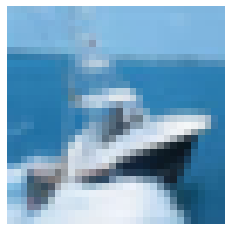

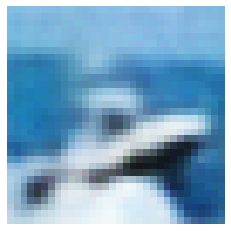

In [5]:
# plot original and reconstructed instance
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3)); plt.axis('off'); plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 3)); plt.axis('off'); plt.show()

### Setting the threshold

Finding good threshold values can be tricky since they are typically not easy to interpret. The `infer_threshold` method helps finding a sensible value. We need to pass a batch of instances `X` and specify what percentage of those we consider to be normal via `threshold_perc`.

In [6]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X_train, threshold_perc=99, batch_size=128)  # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.015
New threshold: 0.00969364859163762


### Create and detect outliers

We can create some outliers by applying a random noise mask to the original instances:

In [7]:
np.random.seed(0)

i = 1

# create masked instance
x = X_test[i].reshape(1, 32, 32, 3)
x_mask, mask = apply_mask(
    x,
    mask_size=(8,8),
    n_masks=1,
    channels=[0,1,2],
    mask_type='normal',
    noise_distr=(0,1),
    clip_rng=(0,1)
)

# predict outliers and reconstructions
sample = np.concatenate([x_mask, x])
preds = od.predict(sample)
x_recon = od.vae(sample).numpy()

Is original outlier? No!
Is perturbed outlier? Yes!


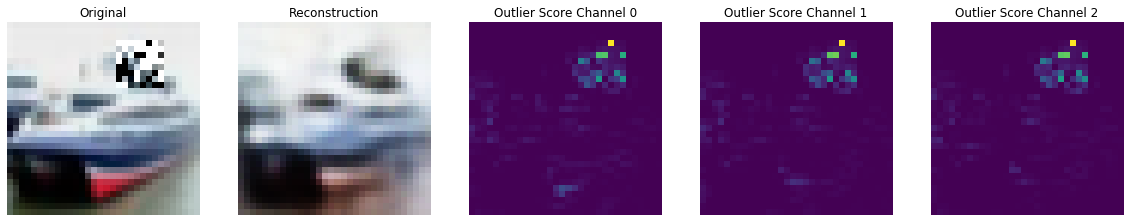

In [8]:
# check if outlier and visualize outlier scores
labels = ['No!', 'Yes!']
print(f"Is original outlier? {labels[preds['data']['is_outlier'][1]]}")
print(f"Is perturbed outlier? {labels[preds['data']['is_outlier'][0]]}")
plot_feature_outlier_image(preds, sample, x_recon, max_instances=1)

### Deploy the detector

For this example we use the open source deployment platform [Seldon Core](https://docs.seldon.io/projects/seldon-core/en/v1.1.0/) and eventing based project [Knative](https://github.com/knative) which allows serverless components
to be connected to event streams. The Seldon Core payload logger sends events containing model requests to the Knative broker which can farm these out to serverless components such as the outlier, drift or adversarial detection modules. Further eventing components can be added to feed off events produced by these components to send onwards to, for example, alerting or storage modules. This happens asynchronously.

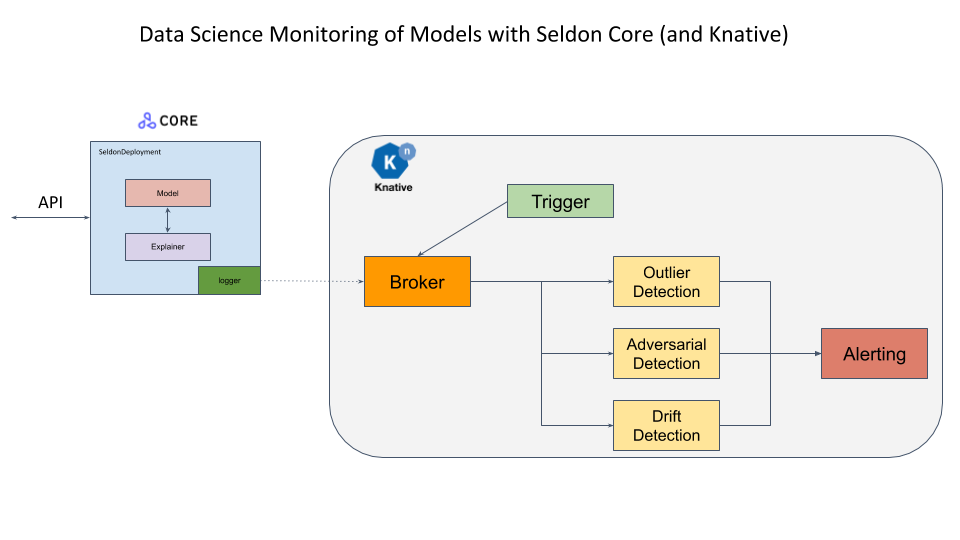

We already configured a cluster on DigitalOcean with Seldon Core installed. The configuration steps to set everything up from scratch are detailed in [this example notebook](https://docs.seldon.io/projects/seldon-core/en/stable/examples/outlier_cifar10.html).

First we get the IP address of the Istio Ingress Gateway. This assumes Istio is installed with a LoadBalancer.

In [9]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

188.166.139.197


In [10]:
SERVICE_HOSTNAMES=!(kubectl get ksvc vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.default.example.com


We define some utility functions for the prediction of the deployed model.

In [11]:
import json
import requests
from typing import Union

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

def predict(x: np.ndarray) -> Union[str, list]:
    """ Model prediction. """
    formData = {
    'instances': x.tolist()
    }
    headers = {}
    res = requests.post(
        'http://'+CLUSTER_IP+'/seldon/default/tfserving-cifar10/v1/models/resnet32/:predict', 
        json=formData, 
        headers=headers
    )
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
    
def outlier(x: np.ndarray) -> Union[dict, list]:
    """ Outlier prediction. """
    formData = {
    'instances': x.tolist()
    }
    headers = {
        "Alibi-Detect-Return-Feature-Score": "true",
        "Alibi-Detect-Return-Instance-Score": "true"
    }
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        od["data"]["feature_score"] = np.array(od["data"]["feature_score"])
        od["data"]["instance_score"] = np.array(od["data"]["instance_score"])
        return od
    else:
        print("Failed with ",res.status_code)
        return []
    
    
def show(x: np.ndarray) -> None:
    plt.imshow(x.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

Let's make a prediction on the original instance:

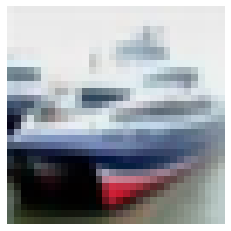

'ship'

In [12]:
show(x)
predict(x)

Let's check the message dumper for the output of the outlier detector:

In [13]:
res=!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container
data = []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[0]))
print("Outlier?",labels[j["data"]["is_outlier"]==[1]])

Outlier? No!


We then make a prediction on the perturbed instance:

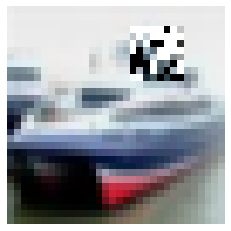

'ship'

In [14]:
show(x_mask)
predict(x_mask)

Although the prediction is still correct, the instance is clearly an outlier:

In [15]:
res=!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper -o jsonpath='{.items[0].metadata.name}') user-container
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[1]))
print("Outlier?",labels[j["data"]["is_outlier"]==[1]])

Outlier? Yes!


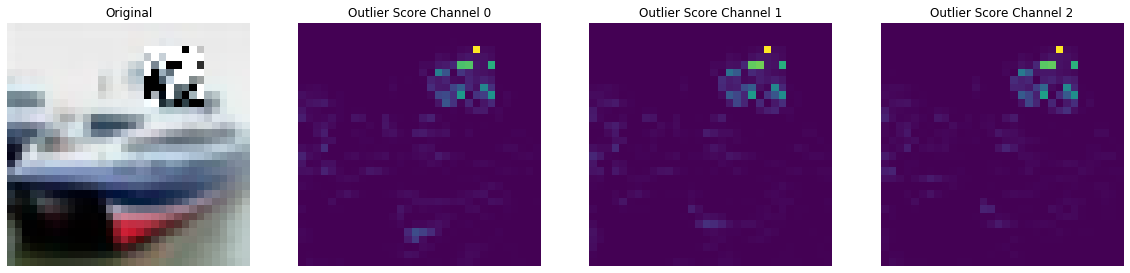

In [16]:
preds = outlier(x_mask)
plot_feature_outlier_image(preds, x_mask, X_recon=None)

## 3. Adversarial detection by matching prediction probabilities

### Method

The adversarial detector is based on [Adversarial Detection and Correction by Matching Prediction Distributions](https://arxiv.org/abs/2002.09364). Usually, autoencoders are trained to find a transformation $T$ that reconstructs the input instance $x$ as accurately as possible with loss functions that are suited to capture the similarities between x and $x'$ such as the mean squared reconstruction error. The novelty of the adversarial autoencoder (AE) detector relies on the use of a classification model-dependent loss function based on a distance metric in the output space of the model to train the autoencoder network. Given a classification model $M$ we optimise the weights of the autoencoder such that the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the model predictions on $x$ and on $x'$ is minimised. Without the presence of a reconstruction loss term $x'$ simply tries to make sure that the prediction probabilities $M(x')$ and $M(x)$ match without caring about the proximity of $x'$ to $x$. As a result, $x'$ is allowed to live in different areas of the input feature space than $x$ with different decision boundary shapes with respect to the model $M$. The carefully crafted adversarial perturbation which is effective around x does not transfer to the new location of $x'$ in the feature space, and the attack is therefore neutralised. Training of the autoencoder is unsupervised since we only need access to the model prediction probabilities and the normal training instances. We do not require any knowledge about the underlying adversarial attack and the classifier weights are frozen during training. 

The detector can be used as follows:

* An adversarial score $S$ is computed. $S$ equals the K-L divergence between the model predictions on $x$ and $x'$.

* If $S$ is above a threshold (explicitly defined or inferred from training data), the instance is flagged as adversarial.

* For adversarial instances, the model $M$ uses the reconstructed instance $x'$ to make a prediction. If the adversarial score is below the threshold, the model makes a prediction on the original instance $x$.

This procedure is illustrated in the diagram below:

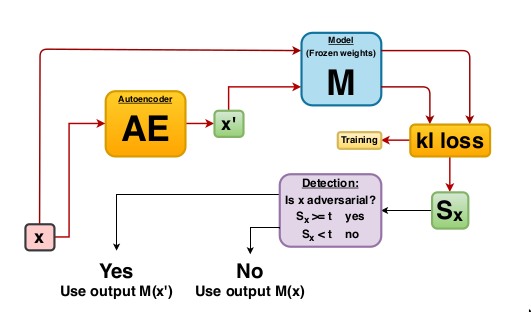

The method is very flexible and can also be used to detect common data corruptions and perturbations which negatively impact the model performance.

In [1]:
# more imports
from sklearn.metrics import roc_curve, auc
from alibi_detect.ad import AdversarialAE
from alibi_detect.datasets import fetch_attack
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.utils.tensorflow import predict_batch

### Utility functions <a name="ad_utils"></a>

In [18]:
# instance scaling and plotting utility functions
def scale_by_instance(X: np.ndarray) -> np.ndarray:
    mean_ = X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    std_ = X.std(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    return (X - mean_) / std_, mean_, std_


def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]


def plot_adversarial(idx: list,
                     X: np.ndarray,
                     y: np.ndarray,
                     X_adv: np.ndarray, 
                     y_adv: np.ndarray,
                     mean: np.ndarray, 
                     std: np.ndarray, 
                     score_x: np.ndarray = None,
                     score_x_adv: np.ndarray = None,
                     X_recon: np.ndarray = None,
                     y_recon: np.ndarray = None,
                     figsize: tuple = (10, 5)) -> None:
    
    # category map from class numbers to names
    cifar10_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                   6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    
    nrows = len(idx)
    ncols = 3 if isinstance(X_recon, np.ndarray) else 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1
    for i in idx:
        
        # rescale images in [0, 1]
        X_adj = (X[i] * std[i] + mean[i]) / 255
        X_adv_adj = (X_adv[i] * std[i] + mean[i]) / 255
        if isinstance(X_recon, np.ndarray):
            X_recon_adj = (X_recon[i] * std[i] + mean[i]) / 255
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x, np.ndarray):
                plt.title('CIFAR-10 Image \n{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('CIFAR-10 Image \n{}'.format(cifar10_map[y[i]]))
        else:
            if isinstance(score_x, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('{}'.format(cifar10_map[y[i]]))
        plt.imshow(X_adj)
        n_subplot += 1
        
        # adversarial image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('Adversarial \n{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('Adversarial \n{}'.format(cifar10_map[y_adv[i]]))
        else:
            if isinstance(score_x_adv, np.ndarray):
                plt.title('{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('{}'.format(cifar10_map[y_adv[i]]))
        plt.imshow(X_adv_adj)
        n_subplot += 1
     
        # reconstructed image
        if isinstance(X_recon, np.ndarray):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            if i == idx[0]:
                plt.title('AE Reconstruction \n{}'.format(cifar10_map[y_recon[i]]))
            else:
                plt.title('{}'.format(cifar10_map[y_recon[i]]))
            plt.imshow(X_recon_adj)
            n_subplot += 1
    
    plt.show()

    
def plot_roc(roc_data: dict, figsize: tuple = (10,5)):
    plot_labels = []
    scores_attacks = []
    labels_attacks = []
    for k, v in roc_data.items():
        if 'original' in k:
            continue
        score_x = roc_data[v['normal']]['scores']
        y_pred = roc_data[v['normal']]['predictions']
        score_v = v['scores']
        y_pred_v = v['predictions']
        labels_v = np.ones(score_x.shape[0])
        idx_remove = np.where(y_pred == y_pred_v)[0]
        labels_v = np.delete(labels_v, idx_remove)
        score_v = np.delete(score_v, idx_remove)
        scores = np.concatenate([score_x, score_v])
        labels = np.concatenate([np.zeros(y_pred.shape[0]), labels_v]).astype(int)
        scores_attacks.append(scores)
        labels_attacks.append(labels)
        plot_labels.append(k)
    
    for sc_att, la_att, plt_la in zip(scores_attacks, labels_attacks, plot_labels):
        fpr, tpr, thresholds = roc_curve(la_att, sc_att)
        roc_auc = auc(fpr, tpr)
        label = str('{}: AUC = {:.2f}'.format(plt_la, roc_auc))
        plt.plot(fpr, tpr, lw=1, label='{}: AUC={:.4f}'.format(plt_la, roc_auc))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}'.format('ROC curve'))
    plt.legend(loc="lower right", ncol=1)
    plt.grid()
    plt.show()

### Rescale data

The ResNet classification model is trained on data standardized by instance:

In [19]:
# rescale data
X_train, mean_train, std_train = scale_by_instance(X_train * 255.)
X_test, mean_test, std_test = scale_by_instance(X_test * 255.)
scale = (mean_train, std_train), (mean_test, std_test)

### Load pre-trained classifier

In [20]:
dataset = 'cifar10'
model = 'resnet56'
clf = fetch_tf_model(dataset, model)

/home/avl/anaconda3/envs/detect/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py:901: UserWarning:

official.vision.image_classification.resnet_cifar_model is not loaded, but a Lambda layer uses it. It may cause errors.



Check the predictions on the test:

In [21]:
y_pred = predict_batch(X_test, clf, batch_size=32).argmax(axis=1)
acc_y_pred = accuracy(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc_y_pred))

Accuracy: 0.9315


### Adversarial attack

We investigate both [Carlini-Wagner (C&W)](https://arxiv.org/abs/1608.04644) and [SLIDE](https://arxiv.org/abs/1904.13000) attacks. You can simply load previously found adversarial instances on the pretrained ResNet-56 model. The attacks are generated by using [Foolbox](https://github.com/bethgelab/foolbox):

In [22]:
# C&W attack
data_cw = fetch_attack(dataset, model, 'cw')
X_train_cw, X_test_cw = data_cw['data_train'], data_cw['data_test']
meta_cw = data_cw['meta'] # metadata with hyperparameters of the attack
# SLIDE attack
data_slide = fetch_attack(dataset, model, 'slide')
X_train_slide, X_test_slide = data_slide['data_train'], data_slide['data_test']
meta_slide = data_slide['meta']

We can verify that the accuracy of the classifier drops to almost $0$%:

In [23]:
y_pred_cw = predict_batch(X_test_cw, clf, batch_size=32).argmax(axis=1)
y_pred_slide = predict_batch(X_test_slide, clf, batch_size=32).argmax(axis=1)
acc_y_pred_cw = accuracy(y_test, y_pred_cw)
acc_y_pred_slide = accuracy(y_test, y_pred_slide)
print('Accuracy: cw {:.4f} -- SLIDE {:.4f}'.format(acc_y_pred_cw, acc_y_pred_slide))

Accuracy: cw 0.0000 -- SLIDE 0.0001


Let's visualise some adversarial instances:

C&W attack...


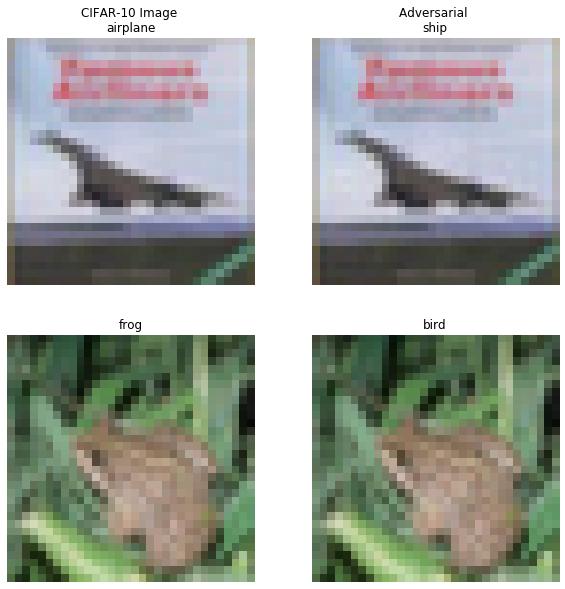

SLIDE attack...


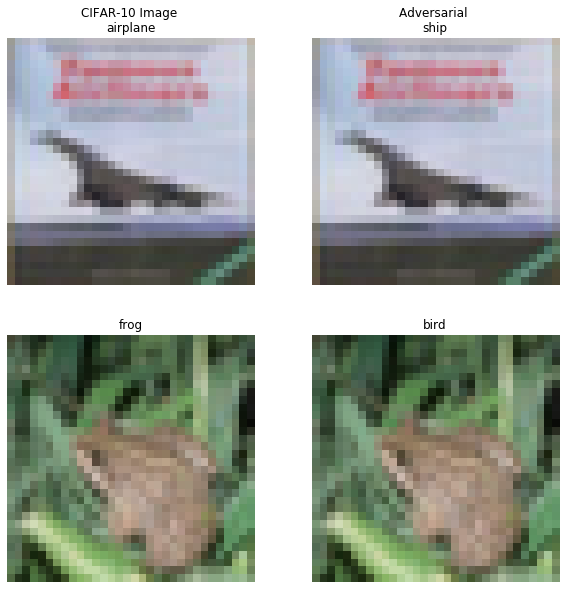

In [24]:
# plot attacked instances
idx = [3, 4]
print('C&W attack...')
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, 
                 mean_test, std_test, figsize=(10, 10))
print('SLIDE attack...')
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, 
                 mean_test, std_test, figsize=(10, 10))

### Load or train and evaluate the adversarial detector

We can again either fetch the pretrained detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad/cifar10/resnet56) or train one from scratch:

In [25]:
load_pretrained = True

In [26]:
filepath = os.path.join(os.getcwd(), 'adversarial')
detector_type = 'adversarial'
detector_name = 'base'
filepath = os.path.join(filepath, detector_name)
if load_pretrained:
    ad = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
else:  # train detector from scratch
    
    # define encoder and decoder networks
    encoder_net = tf.keras.Sequential(
            [
                InputLayer(input_shape=(32, 32, 3)),
                Conv2D(32, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(64, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2D(256, 4, strides=2, padding='same', 
                       activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Flatten(),
                Dense(40)
            ]
        )
    
    decoder_net = tf.keras.Sequential(
        [
                InputLayer(input_shape=(40,)),
                Dense(4 * 4 * 128, activation=tf.nn.relu),
                Reshape(target_shape=(4, 4, 128)),
                Conv2DTranspose(256, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(64, 4, strides=2, padding='same', 
                                activation=tf.nn.relu, kernel_regularizer=l1(1e-5)),
                Conv2DTranspose(3, 4, strides=2, padding='same', 
                                activation=None, kernel_regularizer=l1(1e-5))
            ]
        )
    
    # initialise and train detector
    ad = AdversarialAE(
        encoder_net=encoder_net, 
        decoder_net=decoder_net, 
        model=clf
    )
    ad.fit(X_train, epochs=40, batch_size=64, verbose=True)
    
    # save the trained adversarial detector
    save_detector(ad, filepath)

The detector first reconstructs the input instances which can be adversarial. The reconstructed input is then fed to the classifier to compute the adversarial score. If the score is above a threshold, the instance is classified as adversarial and the detector tries to correct the attack. Let's investigate what happens when we reconstruct attacked instances and make predictions on them:

In [27]:
X_recon_cw = predict_batch(X_test_cw, ad.ae, batch_size=32)
X_recon_slide = predict_batch(X_test_slide, ad.ae, batch_size=32)

In [28]:
y_recon_cw = predict_batch(X_recon_cw, clf, batch_size=32).argmax(axis=1)
y_recon_slide = predict_batch(X_recon_slide, clf, batch_size=32).argmax(axis=1)

Accuracy on attacked vs. reconstructed instances:

In [29]:
acc_y_recon_cw = accuracy(y_test, y_recon_cw)
acc_y_recon_slide = accuracy(y_test, y_recon_slide)
print('Accuracy after C&W attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_cw, acc_y_recon_cw))
print('Accuracy after SLIDE attack {:.4f} -- reconstruction {:.4f}'.format(acc_y_pred_slide, acc_y_recon_slide))

Accuracy after C&W attack 0.0000 -- reconstruction 0.8048
Accuracy after SLIDE attack 0.0001 -- reconstruction 0.8159


The detector restores the accuracy after the attacks from almost $0$% to well over $80$%! We can compute the adversarial scores and inspect some of the reconstructed instances:

In [30]:
score_x = ad.score(X_test, batch_size=32)
score_cw = ad.score(X_test_cw, batch_size=32)
score_slide = ad.score(X_test_slide, batch_size=32)

C&W attack...


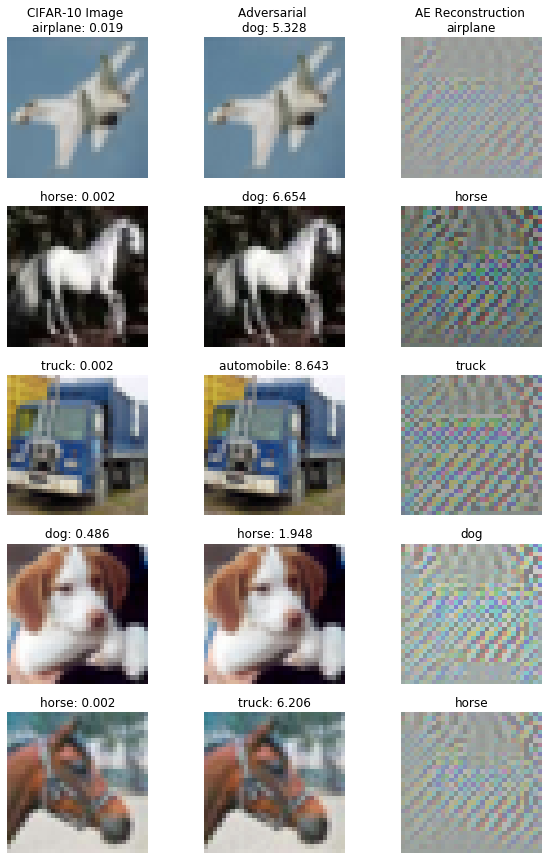

SLIDE attack...


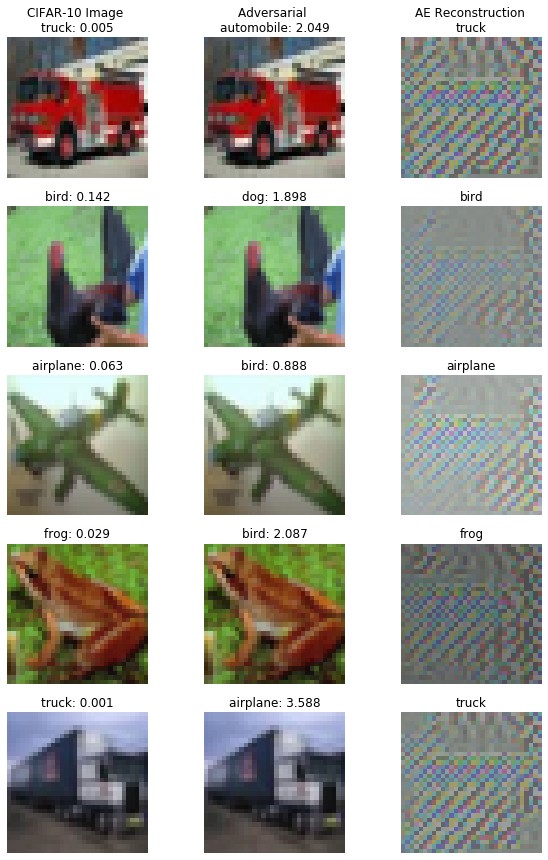

In [31]:
# visualize original, attacked and reconstructed instances with adversarial scores
print('C&W attack...')
idx = [10, 13, 14, 16, 17]
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_cw, X_recon=X_recon_cw, 
                 y_recon=y_recon_cw, figsize=(10, 15))
print('SLIDE attack...')
idx = [23, 25, 27, 29, 34]
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, mean_test, std_test, 
                 score_x=score_x, score_x_adv=score_slide, X_recon=X_recon_slide, 
                 y_recon=y_recon_slide, figsize=(10, 15))

The ROC curves and AUC values show the effectiveness of the adversarial score to detect adversarial instances:

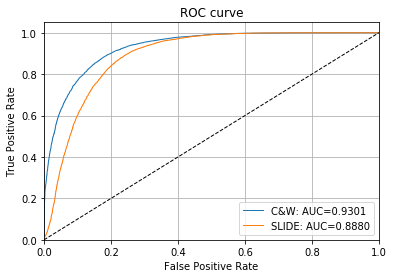

In [32]:
# plot roc curve
roc_data = {
    'original': {'scores': score_x, 'predictions': y_pred},
    'C&W': {'scores': score_cw, 'predictions': y_pred_cw, 'normal': 'original'},
    'SLIDE': {'scores': score_slide, 'predictions': y_pred_slide, 'normal': 'original'}
}

plot_roc(roc_data)

The threshold for the adversarial score can be set via ```infer_threshold```. We need to pass a batch of instances $X$ and specify what percentage of those we consider to be normal via `threshold_perc`. Assume we have only normal instances some of which the model has misclassified leading to a higher score if the reconstruction picked up features from the correct class or some might look adversarial in the first place. As a result, we set our threshold at $95$%:

In [33]:
ad.infer_threshold(X_test, threshold_perc=95, margin=0., batch_size=32)
print('Adversarial threshold: {:.4f}'.format(ad.threshold))

Adversarial threshold: 2.6722


The `correct` method of the detector executes the diagram in Figure 1. First the adversarial scores is computed. For instances where the score is above the threshold, the classifier prediction on the reconstructed instance is returned. Otherwise the original prediction is kept. The method returns a dictionary containing the metadata of the detector, whether the instances in the batch are adversarial (above the threshold) or not, the classifier predictions using the correction mechanism and both the original and reconstructed predictions. Let's illustrate this on a batch containing some adversarial (C&W) and original test set instances:

In [34]:
n_test = X_test.shape[0]
np.random.seed(0)
idx_normal = np.random.choice(n_test, size=1600, replace=False)
idx_cw = np.random.choice(n_test, size=400, replace=False)

X_mix = np.concatenate([X_test[idx_normal], X_test_cw[idx_cw]])
y_mix = np.concatenate([y_test[idx_normal], y_test[idx_cw]])
print(X_mix.shape, y_mix.shape)

(2000, 32, 32, 3) (2000,)


Let's check the model performance:

In [35]:
y_pred_mix = predict_batch(X_mix, clf, batch_size=32).argmax(axis=1)
acc_y_pred_mix = accuracy(y_mix, y_pred_mix)
print('Accuracy {:.4f}'.format(acc_y_pred_mix))

Accuracy 0.7380


This can be improved with the correction mechanism:

In [36]:
preds = ad.correct(X_mix, batch_size=32)
acc_y_corr_mix = accuracy(y_mix, preds['data']['corrected'])
print('Accuracy {:.4f}'.format(acc_y_corr_mix))

Accuracy 0.8205


There are a few other tricks highlighted in the [paper](https://arxiv.org/abs/2002.09364) (**temperature scaling** and **hidden layer K-L divergence**) and implemented in Alibi Detect which can further boost the adversarial detector's performance. Check [this example notebook](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/ad_ae_cifar10.html) for more details.

## 4. Drift detection with Kolmogorov-Smirnov

### Method

The drift detector applies feature-wise two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (K-S) tests. For multivariate data, the obtained p-values for each feature are aggregated either via the [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) or the [False Discovery Rate](http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_hochberg1995.pdf) (FDR) correction. The Bonferroni correction is more conservative and controls for the probability of at least one false positive. The FDR correction on the other hand allows for an expected fraction of false positives to occur.

For high-dimensional data, we typically want to reduce the dimensionality before computing the feature-wise univariate K-S tests and aggregating those via the chosen correction method. Following suggestions in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953), we incorporate Untrained AutoEncoders (UAE), black-box shift detection using the classifier's softmax outputs ([BBSDs](https://arxiv.org/abs/1802.03916)) and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) as out-of-the box preprocessing methods. Preprocessing methods which do not rely on the classifier will usually pick up drift in the input data, while BBSDs focuses on label shift. The [adversarial detector](https://arxiv.org/abs/2002.09364) which is part of the library can also be transformed into a drift detector picking up drift that reduces the performance of the classification model. We can therefore combine different preprocessing techniques to figure out if there is drift which hurts the model performance, and whether this drift can be classified as input drift or label shift.

Note that the library also has a drift detector based on the [Maximum Mean Discrepancy](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_mmd_cifar10.html#) and contains [drift on text functionality](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_text_imdb.html) as well.


### Dataset

We will use the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)) to evaluate the drift detector. The instances in
CIFAR-10-C come from the test set in CIFAR-10 but have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances.

In [37]:
# yet again import stuff
from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import UAE, HiddenOutput
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

We can select from the following corruption types at 5 severity levels:

In [38]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [39]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the K-S test. We also split the corrupted data by corruption type:

In [40]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(scale_by_instance(X_corr[i * n_test:(i + 1) * n_test])[0])

(5000, 32, 32, 3) (5000, 32, 32, 3)


We can visualise the same instance for each corruption type:

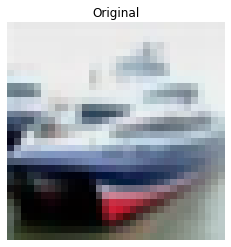

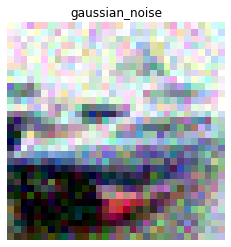

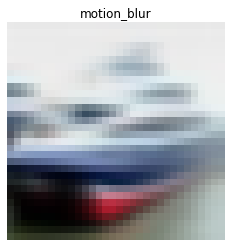

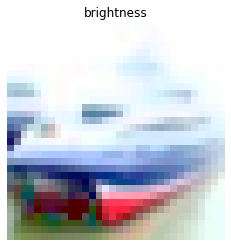

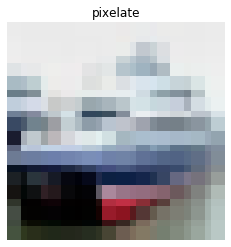

In [41]:
# plot original and corrupted images
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow((X_test[i] * std_test[i] + mean_test[i]) / 255.)
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a ResNet-32 classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [42]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(X_test, y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(X_c[_], y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


Given the drop in performance, it is important that we detect the harmful data drift!

### Detect drift

We are trying to detect data drift on high-dimensional (*32x32x3*) data using an aggregation of univariate K-S tests. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: **UAE** (Untrained AutoEncoder), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA** (using `scikit-learn`). 

#### Untrained AutoEncoder

First we try UAE:

In [43]:
tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)
uae = UAE(encoder_net=encoder_net)
preprocess_kwargs = {'model': uae, 'batch_size': 128}

# initialise drift detector
p_val = .05
cd = KSDrift(
    p_val=p_val,        # p-value for K-S test 
    X_ref=X_ref,       # test against original test set
    preprocess_kwargs=preprocess_kwargs
)

Let's check whether the detector thinks drift occurred within the original test set:

In [44]:
preds_h0 = cd.predict(X_h0, return_p_val=True)
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


As expected, no drift occurred. We can also inspect the feature-wise K-S statistics, threshold value and p-values for each univariate K-S test by (encoded) feature before the multivariate correction. Most of them are well above the $0.05$ threshold:

In [45]:
# print stats for H0
print('K-S statistics:')
print(preds_h0['data']['distance'])
print(f"\nK-S statistic threshold: {preds_h0['data']['threshold']}")
print('\np-values:')
print(preds_h0['data']['p_val'])

K-S statistics:
[0.017  0.013  0.0124 0.0234 0.0156 0.0144 0.025  0.0144 0.0216 0.0112
 0.0122 0.0146 0.012  0.0154 0.015  0.0148 0.012  0.0158 0.0104 0.0144
 0.0116 0.0148 0.0194 0.0112 0.0176 0.0154 0.0152 0.0158 0.0166 0.0202
 0.0208 0.0196]

K-S statistic threshold: 0.0015625

p-values:
[0.46531922 0.79201305 0.8367454  0.12939005 0.5769981  0.677735
 0.08786641 0.677735   0.19387017 0.912423   0.850771   0.66088647
 0.8642828  0.5936282  0.62716705 0.6440195  0.8642828  0.5604951
 0.94969434 0.677735   0.88960564 0.6440195  0.30355498 0.912423
 0.420929   0.5936282  0.61036026 0.5604951  0.496191   0.25943416
 0.22956407 0.2920585 ]


Let's now check the predictions on the perturbed data:

In [46]:
# print stats for corrupted data
for x, c in zip(X_c, corruption):
    preds = cd.predict(x, return_p_val=True)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[1.3873853e-04 2.6511249e-01 9.4417885e-02 3.8390055e-01 7.1598392e-04
 5.9501763e-04 1.7882723e-02 6.8460542e-01 2.9989053e-02 3.7781857e-02
 6.6516680e-01 3.5206401e-07 4.4194090e-05 7.9351515e-03 6.5543061e-01
 1.0220607e-04 1.9904150e-01 8.7863362e-01 1.1572546e-02 8.7863362e-01
 2.7950103e-03 1.1150700e-02 3.6837953e-01 4.4130555e-01 7.8937606e-05
 5.1594800e-03 6.2871156e-03 1.3455943e-03 9.7143359e-02 1.4105450e-07
 1.7258449e-02 1.4648294e-01]

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[3.75149103e-13 1.34077845e-02 2.96938539e-01 1.38920277e-01
 5.03090501e-01 1.71172902e-01 6.25065863e-02 5.15948003e-03
 4.85032678e-01 2.16893386e-03 7.48323351e-02 1.28741434e-03
 1.24597345e-02 2.57197134e-05 1.32995670e-09 7.83811294e-10
 7.93515146e-03 3.10395747e-01 2.09074125e-01 5.97174764e-01
 5.95017627e-04 9.71433595e-02 3.38559955e-01 3.31362933e-01
 7.15983915e-04 3.45860541e-01 5.68405211e-01 

#### BBSDs

For **BBSDs**, we use the classifier's softmax outputs for black-box shift detection. This method is based on [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916).

Here we use the output of the softmax layer to detect the drift, but other hidden layers can be extracted as well by setting *'layer'* to the index of the desired hidden layer in the model:

In [47]:
# use output softmax layer
preprocess_kwargs = {'model': HiddenOutput(model=clf, layer=-1), 'batch_size': 128}

cd = KSDrift(
    p_val=p_val,
    X_ref=X_ref,
    preprocess_kwargs=preprocess_kwargs
)

There is again no drift on the original held out test set:

In [48]:
preds_h0 = cd.predict(X_h0)
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print('\np-values:')
print(preds_h0['data']['p_val'])

Drift? No!

p-values:
[0.11774229 0.52796143 0.19387017 0.20236294 0.496191   0.72781175
 0.12345381 0.420929   0.8367454  0.7604178 ]


We compare this with the perturbed data:

In [49]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Corruption type: motion_blur
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Corruption type: brightness
Drift? Yes!
Feature-wise p-values:
[0.0000000e+00 4.2024049e-15 2.8963613e-33 4.8499879e-07 2.3718185e-15
 1.2473309e-05 2.9714003e-30 1.0611427e-09 4.6048109e-12 4.1857830e-17]

Corruption type: pixelate
Drift? Yes!
Feature-wise p-values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



For more functionality and examples, such as updating the reference data with reservoir sampling or picking another multivariate correction mechanism, check out [this example notebook](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html).

### Leveraging the adversarial detector for malicious drift detection

While monitoring covariate and predicted label shift is all very interesting and exciting, at the end of the day we are mainly interested in whether the drift actually hurt the model performance significantly. To this end, we can leverage the adversarial detector and measure univiariate drift on the adversarial scores! 

In [50]:
np.random.seed(0)
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
X_ref = scale_by_instance(X_test[idx])[0]

cd = KSDrift(
    p_val=.05,
    X_ref=X_ref,
    preprocess_fn=ad.score,  # adversarial score fn = preprocess step
    preprocess_kwargs={'batch_size': 128}
)

Make drift predictions on the original test set and corrupted data:

In [51]:
# evaluate classifier on different datasets
clf_accuracy['h0'] = clf.evaluate(X_h0, y_h0, batch_size=128, verbose=0)[1]
preds_h0 = cd.predict(X_h0)
print('H0: Accuracy {:.4f} -- Drift? {}'.format(
    clf_accuracy['h0'], labels[preds_h0['data']['is_drift']]))
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print('{}: Accuracy {:.4f} -- Drift? {}'.format(
        c, clf_accuracy[c],labels[preds['data']['is_drift']]))

H0: Accuracy 0.9286 -- Drift? No!
gaussian_noise: Accuracy 0.2208 -- Drift? Yes!
motion_blur: Accuracy 0.6339 -- Drift? Yes!
brightness: Accuracy 0.8913 -- Drift? Yes!
pixelate: Accuracy 0.3666 -- Drift? Yes!


We can therefore **use the scores of the detector itself to quantify the harmfulness of the drift**! We can generalise this to all the corruptions at each severity level in CIFAR-10-C.

On the plot below we show the mean values and standard deviations of the adversarial scores per severity level. The plot shows the mean adversarial scores (lhs) and ResNet-32 accuracies (rhs) for increasing data corruption severity levels. Level 0 corresponds to the original test set. Harmful scores  are scores from instances which have been flipped from the correct to an incorrect prediction because of the corruption. Not harmful means that the prediction was unchanged after the corruption. The chart can be reproduced in [this notebook](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_ks_cifar10.html).

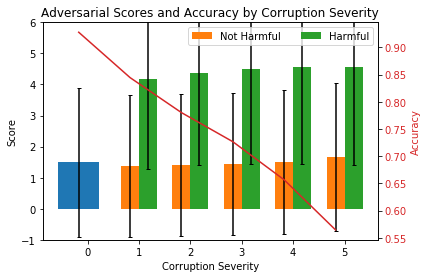

### Deploy

We can deploy the drift detector in a similar fashion as the [outlier detector](#od_deploy). For a more detailed step-by-step overview of the deployment process, check [this notebook](https://docs.seldon.io/projects/seldon-core/en/stable/examples/drift_cifar10.html).

In [52]:
SERVICE_HOSTNAMES=!(kubectl get ksvc drift-detector -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CD)

drift-detector.default.example.com


The deployed drift detector accumulates requests until a predefined `drift_batch_size` is reached, in our case $5000$ which is defined in the [*yaml* for the deployment](https://github.com/SeldonIO/seldon-core/blob/master/components/drift-detection/cifar10/cifar10.yaml) and set in the [drift detector wrapper](https://github.com/SeldonIO/seldon-core/blob/master/components/alibi-detect-server/adserver/cd_model.py). After $5000$ instances, the batch is cleared and fills up again.

In [54]:
from tqdm.notebook import tqdm

drift_batch_size = 5000

# accumulate batches
for i in tqdm(range(0, drift_batch_size, 100)):
    x = X_h0[i:i+100]
    predict(x)

# check message dumper
res=!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper-drift -o jsonpath='{.items[0].metadata.name}') user-container
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[0]))
print("Drift?", labels[j["data"]["is_drift"]==1])


Drift? No!


We now run the same test on some corrupted data:

In [55]:
c = 0

print(f'Corruption: {corruption[c]}')

# accumulate batches
for i in tqdm(range(0, drift_batch_size, 100)):
    x = X_c[c][i:i+100]
    predict(x)

# check message dumper
res=!kubectl logs $(kubectl get pod -l serving.knative.dev/configuration=message-dumper-drift -o jsonpath='{.items[0].metadata.name}') user-container
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[1]))
print("Drift?", labels[j["data"]["is_drift"]==1])

Corruption: gaussian_noise



Drift? Yes!
